# Code for problem 7

To access the class for the ARMA models visit: https://github.com/FrancoCalle/EconomicsPhD/tree/main/Third_Quarter/pset6

Consider the panel problem set on earnings posted on Canvas. Compute the parameters of the following earnings dynamic models using the NLSY. $X_{it} \perp U_{i't}$ at all t for all i, and $U_{it} \perp U_{i't''}$ for all i, i' for t $t \neq t'$
In all cases, $E(\epsilon_{it}) = 0$. $i = 1,...,I$; $t = 1, ...,  T$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

df_full = pd.read_stata('https://dl.dropboxusercontent.com/s/reqqx19nliefyw4/NLSY.dta')
df_extract = pd.read_stata('https://dl.dropboxusercontent.com/s/v7dt5q45eysau9y/nlsy79_extract.dta')
df_extract['male_raw'] = df_extract['male']
df_extract['male'] = (df_extract['male_raw'] == 'MALE')

df = df_full.copy()

## Data Cleaning:

In [2]:
## Data cleaning:
##---------------
df_educ = df_extract.groupby('id').apply(lambda df: df['yearseduc_age30'].mean())
df_educ.name = 'yearseduc_age30'
df = df.join(df_educ, on=['id'])

# Drop Missings:
df.dropna(
    subset=[
    'hrs_worked_pastyear',
    'yearly_inc',
    'nchld',
    'marstat',
    'yearseduc_age30',
    'family_net_wealth'
    ],
    inplace=True
)


# Define number of children, capped at 5
df['children_max5'] = df['nchld'].clip(upper=5)
# Define marital status indicators
df['marstat_2'] = (df['marstat'] == 2).astype(np.float64)
df['marstat_3'] = (df['marstat'] == 3).astype(np.float64)
# Define family net worth (in millions)
df['family_net_wealth_millions'] = df['family_net_wealth'] / 1e6

# Define people who worked as people who worked 100 or more hours (lower values
# are possibly misresponses or otherwise edge cases) AND who earned more than $500
# dollars (same rationale)

df['worked'] = (df['hrs_worked_pastyear'] > 100.) & (df['yearly_inc'] > 500.)
df['hourly_wage'] = (df['yearly_inc'] / (df['hrs_worked_pastyear'] + 1e-50)) *df['worked']
df['ln_hourly_wage'] = np.log(df['hourly_wage'])
df = df.loc[df['ln_hourly_wage']>-np.inf]

# People are identified by id:
df.sort_values('id').head()

# Check how many obs are by year:
df['year'].sort_values().value_counts()

# Check observations by id:
id_counts = (df['id'].value_counts()
            .reset_index()
            .rename(columns={'id': 'counts', 'index': 'id'})
            .query('counts == 16')
            .id
            )


nlsyBalancedDataFrame = df.loc[df['id'].isin(id_counts),:]

# Add year and individual dummies for fixed effects (Dropped first):
df_year_dummies = pd.get_dummies(
    nlsyBalancedDataFrame['year'].astype(int), drop_first=True, prefix='year', dtype=np.float64
)

df_individual_dummies = pd.get_dummies(
    nlsyBalancedDataFrame['id'].astype(int), drop_first=True, prefix='id', dtype=np.float64
)

year_dummy_columns = list(df_year_dummies.columns)[1:]
individual_dummy_columns = list(df_individual_dummies.columns)

# Sort data
nlsyBalancedDataFrame = pd.concat([nlsyBalancedDataFrame, df_year_dummies, df_individual_dummies], axis=1).sort_values(by = ['id', 'year'])

# Get lagged outcome and other covariates:
lagedDataFrame = nlsyBalancedDataFrame[['id',
                'year',
                'ln_hourly_wage',
                'age',
                'yearseduc_age30',
                'family_net_wealth_millions'
                ]].rename(columns={'ln_hourly_wage':'ln_hourly_wage_lag',
                'age':'age_lag',
                'yearseduc_age30':'yearseduc_age30_lag',
                'family_net_wealth_millions':'family_net_wealth_millions_lag'})

lagedDataFrame['year'] = (lagedDataFrame['year'] + 1)

#Obtain lagged variable:
nlsyBalancedDataFrame = nlsyBalancedDataFrame.merge(lagedDataFrame, how = 'left', on=['id','year'])

#Drop observations for first year
nlsyBalancedDataFrame = nlsyBalancedDataFrame.dropna(subset=['ln_hourly_wage_lag'])

nlsyBalancedDataFrame['constant'] = 1


## Construct matrices for estimation:
##----------------------------------
marketWageDeterminants = [
                        'constant', 'age', 'family_net_wealth_millions', #'yearseduc_age30',
                        ]

marketWageDeterminantsLag = [
                        'age_lag','family_net_wealth_millions_lag',
                        ]

laggedDependentVariable = ['ln_hourly_wage_lag']

dependentVariable = ['ln_hourly_wage']

yLog = nlsyBalancedDataFrame[dependentVariable].values
yLogLagged = nlsyBalancedDataFrame[laggedDependentVariable].values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Arrange data to feed the AR and ARMA functions

In [3]:
#Matrices are of N X T dimensions:
y = (nlsyBalancedDataFrame
    .sort_values(by=['id','year'])
    .pivot_table(index = 'id',
                    columns='year',
                    values = dependentVariable)).values.T

x1 = (nlsyBalancedDataFrame
    .sort_values(by=['id','year'])
    .pivot_table(index = 'id',
                    columns='year',
                    values = marketWageDeterminants[1])).values.T

x2 = (nlsyBalancedDataFrame
    .sort_values(by=['id','year'])
    .pivot_table(index = 'id',
                    columns='year',
                    values = marketWageDeterminants[2])).values.T

X = [x1, x2]

### Part A: Fit model with fixed effects:

$\ln Y_{it} = \alpha' X_{it} + \beta \ln Y_{i,t-1} + f_i + \epsilon_{it}$

We can modify this model to have Ln(Y) instead of Y.

$\ln Y_{it} = \alpha' X_{it} + \beta \ln Y_{i,t-1} + f_i + \epsilon_{it}$

for all t and i. We can demean both the dependent and explanatory variables so that we can get rid of fixed effects. Denote them $\overline{\ln Y}_{i}$, $\bar{X}_{i}$ and $\bar{Y}_{i}$

\begin{align*}
(\ln Y_{it} - \overline{\ln Y}_{i}) = \alpha' (X_{it} - \bar{X}_i) + \beta (\ln Y_{i,t-1} - \overline{\ln Y}_{i}) + \epsilon_{it}
\end{align*}


In [4]:
from ar_mle import mlePanelAR
from functools import reduce

# Test Model E.A:
ar = mlePanelAR()

In [5]:
y_demean, xx_demean, YY_mean, XX_mean = ar.demeanVariables(y,X)

initial_parameters =  np.ones(4)*.5

fun = lambda parameters: ar.objectiveFunction(
y_demean,
xx_demean,
parameters,
ar.maximumLikelihood
)

# Optimize
result = ar.optimize(fun, initial_parameters)

#Retrieve Parameters
parameters_hat_1A = result.x

#Predict model using estimates:
predictionError1A = ar.predict_model(y_demean, xx_demean, parameters_hat_1A).flatten()

print('Parameters:', parameters_hat_1A)
print('MSE:', np.mean(predictionError1A**2))

Optimization terminated successfully.
         Current function value: 1191.418496
         Iterations: 330
         Function evaluations: 651
Parameters: [0.05729361 0.03444936 0.27854534 0.36149134]
MSE: 0.13067598529132088


### Part B: Fit model with $\beta = 0$ and autorregressive error term:

\begin{align*}
\ln Y_{it} = \alpha' X_{it} + \rho \ln Y_{i,t-1} - \rho \alpha' X_{it-1} + \epsilon_{it} 
\end{align*}



In [6]:
initial_parameters =  np.ones(6)*.5
initial_parameters[0] = parameters_hat_1A[0]
initial_parameters[1] = parameters_hat_1A[1]
initial_parameters[-1] = parameters_hat_1A[-1]

fun = lambda parameters: ar.objectiveFunction(
y_demean,
xx_demean,
parameters,
ar.maximumLikelihoodModelB
)

result = ar.optimize(fun, initial_parameters)

parameters_hat_1B = result.x

predictionError1B = ar.predict_modelB(y_demean, xx_demean, parameters_hat_1B).flatten()

print('Parameters:', parameters_hat_1B)
print('MSE:', np.mean(predictionError1B**2))

Optimization terminated successfully.
         Current function value: 1173.733032
         Iterations: 715
         Function evaluations: 1248
Parameters: [ 0.09489819  0.02015229  0.04113768 -0.04085347  0.29738176  0.35934371]
MSE: 0.12912790648715922


### Part C: Fit model with $\beta = 1$ and autorregressive error term:
\begin{align*}
\Delta \ln Y_{it} = \alpha' X_{it} + \rho \ln Y_{i,t-1} - \rho \alpha' X_{it-1} + \epsilon_{it} 
\end{align*}


In [7]:
initial_parameters = parameters_hat_1B.copy()

fun = lambda parameters: ar.objectiveFunction(
y_demean,
xx_demean,
parameters,
ar.maximumLikelihoodModelC
)

result = ar.optimize(fun, initial_parameters)

parameters_hat_1C = result.x

predictionError1C = ar.predict_modelC(y_demean, xx_demean, parameters_hat_1C).flatten()

print('Parameters:', parameters_hat_1C)
print('MSE:', np.mean(predictionError1C**2))

Optimization terminated successfully.
         Current function value: 1173.733032
         Iterations: 988
         Function evaluations: 1649
Parameters: [ 0.09489819  0.02015225  0.04113768 -0.04085351 -0.70261826  0.35934372]
MSE: 0.12912790648715916


### Part D: Fit model with $\beta = 0$ and unit root error term :
\
\begin{align*}
    \ln Y_{it} &= \alpha' X_{it} + U_{it} \\ 
    &= \alpha' X_{it} +  U_{i,t-1} + \epsilon_{it} \\
     &= \alpha' X_{it} +  (\ln Y_{i,t-1} - \alpha' X_{it-1}) + \epsilon_{it} \\
     &= \alpha' X_{it} +  \ln Y_{i,t-1} -  \alpha' X_{it-1} + \epsilon_{it} \\
     \implies \Delta \ln Y_{it} &= \alpha' \Delta \ln X_{it} + \epsilon_{it}
\end{align*}

In [8]:
initial_parameters = parameters_hat_1C.copy()
initial_parameters = np.append(initial_parameters[:2],initial_parameters[4:])

fun = lambda parameters: ar.objectiveFunction(
    y,
    X,
    parameters,
    ar.maximumLikelihoodModelD
)

result = ar.optimize(fun, initial_parameters)

parameters_hat_1D = result.x

predictionError1D = ar.predict_modelD(y_demean, xx_demean, parameters_hat_1D).flatten()

print('Parameters:', parameters_hat_1D)
print('MSE:', np.mean(predictionError1D**2))

Optimization terminated successfully.
         Current function value: 1872.212127
         Iterations: 232
         Function evaluations: 503
Parameters: [ 0.0924979  -0.00379407 -0.73433779  0.45469006]
MSE: 0.2067430422913959


## Now income shock $\epsilon_{it}$ follows a MA(1) process:

First, arrange data so we can estimate the new models.
Also, load the mlePanelARMA package.

In [20]:
from arma_mle import mlePanelARMA

# Test Model E.A:
arma = mlePanelARMA()

### Part E.A: Fit model A with MA(1).

\begin{align*}
    \ln Y_{it} = \alpha'X_{it} + \beta Y_{it-1} + f_i + \epsilon_{it} - \phi \epsilon_{it-1}
\end{align*}

In [21]:
y_demean, xx_demean, YY_mean, XX_mean = arma.demeanVariables(y,X)

initial_parameters =  np.ones(5)*.5

fun = lambda parameters: arma.objectiveFunction(
y_demean,
xx_demean,
parameters,
arma.maximumLikelihood
)

# Optimize
result = arma.optimize(fun, initial_parameters)

#Retrieve Parameters
parameters_hat_A = result.x

#Predict model using estimates:
predictionErrorA = arma.predict_model(y_demean, xx_demean, parameters_hat_A).flatten()

print('Parameters:', parameters_hat_A)
print('MSE:', np.mean(predictionErrorA**2))

Optimization terminated successfully.
         Current function value: 1190.987850
         Iterations: 462
         Function evaluations: 803
Parameters: [0.05528268 0.03351843 0.30132434 0.0300132  0.36143889]
MSE: 0.13063806957191704


### Part E.B: Fit model B with MA(1):

\begin{align*}
    \ln Y_{it} &= \alpha'X_{it} + \rho U_{i,t-1} + \epsilon_{it} - \phi  \epsilon_{it-1} \\
    &= \alpha'X_{it} + \rho (\ln Y_{i t-1} - \alpha'X_{it-1} - \epsilon_{it-1} + \phi  \epsilon_{it-2}) + \epsilon_{it} - \phi  \epsilon_{it-1}\\
    &=  \alpha'X_{it} + \rho \ln Y_{i t-1} - \rho \alpha'X_{it-1} - \rho \epsilon_{it-1} + \rho \phi  \epsilon_{it-2} + \epsilon_{it} - \phi  \epsilon_{it-1} \\
    &=\alpha'X_{it} + \rho \ln Y_{i t-1} - \rho \alpha'X_{it-1} + \epsilon_{it} - (\phi + \rho)  \epsilon_{it-1} +  \rho \phi  \epsilon_{it-2}
\end{align*}


In [22]:
initial_parameters =  np.ones(8)*.5
initial_parameters[0] = parameters_hat_A[0]
initial_parameters[1] = parameters_hat_A[1]
initial_parameters[-1] = parameters_hat_A[-1]

fun = lambda parameters: arma.objectiveFunction(
y_demean,
xx_demean,
parameters,
arma.maximumLikelihoodModelB
)

result = arma.optimize(fun, initial_parameters)

parameters_hat_B = result.x

predictionErrorB = arma.predict_modelB(y_demean, xx_demean, parameters_hat_B).flatten()

print('Parameters:', parameters_hat_B)
print('MSE:', np.mean(predictionErrorB**2))

Optimization terminated successfully.
         Current function value: 1007.849151
         Iterations: 1895
         Function evaluations: 2878
Parameters: [ 0.1000917   0.01985855  0.05332089 -0.02129857  0.3499744   0.10186575
  0.0044975   0.34880376]
MSE: 0.12166406277971031


### Part E.C: Fit model C with MA(1) :

\begin{align*}
    \Delta \ln Y_{it} &= \alpha'X_{it} + \rho \ln Y_{i t-1} - \rho \alpha'X_{it-1} + \epsilon_{it} - (\phi + \rho)  \epsilon_{it-1} +  \rho \phi  \epsilon_{it-2}
\end{align*}


In [23]:
initial_parameters = parameters_hat_B.copy()

fun = lambda parameters: arma.objectiveFunction(
y_demean,
xx_demean,
parameters,
arma.maximumLikelihoodModelC
)

result = arma.optimize(fun, initial_parameters)

parameters_hat_C = result.x

predictionErrorC = arma.predict_modelC(y_demean, xx_demean, parameters_hat_C).flatten()

print('Parameters:', parameters_hat_C)
print('MSE:', np.mean(predictionErrorC**2))

Optimization terminated successfully.
         Current function value: 1007.849151
         Iterations: 2566
         Function evaluations: 3797
Parameters: [ 0.1000917   0.01985851  0.05332089 -0.0212986  -0.65002557  0.10186579
  0.00449753  0.34880376]
MSE: 0.1216640627797103


### Part E.D: Fit model D with MA(1):

\begin{align*}
    \ln Y_{it}  &=\alpha' X_{it} + \ln Y_{i t-1} - \alpha'X_{it-1} + \epsilon_{it} - (1 + \phi)  \epsilon_{it-1} +  \phi  \epsilon_{it-2} \\
    \implies \Delta \ln Y_{it}  &=\alpha' \Delta X_{it}  + \epsilon_{it} - (1 + \phi)  \epsilon_{it-1} +  \phi  \epsilon_{it-2}   
\end{align*}

In [24]:
initial_parameters = parameters_hat_C.copy()
initial_parameters = np.append(initial_parameters[:2],initial_parameters[5:])

fun = lambda parameters: arma.objectiveFunction(
    y,
    X,
    parameters,
    arma.maximumLikelihoodModelD
)

result = arma.optimize(fun, initial_parameters)

parameters_hat_D = result.x

predictionErrorD = arma.predict_modelD(y_demean, xx_demean, parameters_hat_D).flatten()

print('Parameters:', parameters_hat_D)
print('MSE:', np.mean(predictionErrorD**2))

Optimization terminated successfully.
         Current function value: 1413.424238
         Iterations: 474
         Function evaluations: 801
Parameters: [ 0.08593939 -0.00615268  0.48340014 -0.054898    0.40410317]
MSE: 0.1632993805820219


### Compute Likelihood Ratios:

The objective of this section is to learn which specification fits the data better. Recall that the likelihood ratio test is as follows:

\begin{align*}
    LR = -2( \ln \mathcal(L(\theta_A)) - \ln \mathcal(L(\theta_0)) )
\end{align*}

In [25]:
# Get all errors:
predictionError1A = ar.predict_model(y_demean, xx_demean, parameters_hat_1A)[1:,:].flatten()
predictionError1B = ar.predict_modelB(y_demean, xx_demean, parameters_hat_1B)[1:,:].flatten()
predictionError1C = ar.predict_modelC(y_demean, xx_demean, parameters_hat_1C)[1:,:].flatten()
predictionError1D = ar.predict_modelD(y_demean, xx_demean, parameters_hat_1D)[1:,:].flatten()

predictionErrorList = [
predictionError1A,
predictionError1B,
predictionError1C,
predictionError1D,
predictionErrorA,
predictionErrorB,
predictionErrorC,
predictionErrorD
]

predictionErrorList = [
parameters_hat_1A,
parameters_hat_1B,
parameters_hat_1C,
parameters_hat_1D,
parameters_hat_A,
parameters_hat_B,
parameters_hat_C,
parameters_hat_D
]

nModels = len(predictionErrorList)
ModelComparison = np.zeros((nModels,nModels))


for ii in range(nModels):
    for jj in range(nModels):
        if ii != jj:
            ModelComparison[ii,jj] = arma.computeLikelihoodRatio(
                predictionErrorList[ii], 
                predictionErrorList[jj], 
                predictionErrorList[ii][-1], 
                predictionErrorList[jj][-1])


In [167]:
print(np.around(ModelComparison,3)) # Positive LR ratio base model fits better
pd.DataFrame(np.around(ModelComparison,3)).to_csv('LikelihoodRatioTest.csv')

[[ 0.    -0.31   2.828  3.857 -0.093 -0.783  1.683  1.784]
 [ 0.31   0.     3.138  4.167  0.217 -0.473  1.993  2.094]
 [-2.828 -3.138  0.     1.029 -2.921 -3.612 -1.145 -1.044]
 [-3.857 -4.167 -1.029  0.    -3.949 -4.64  -2.174 -2.073]
 [ 0.093 -0.217  2.921  3.949  0.    -0.691  1.775  1.877]
 [ 0.783  0.473  3.612  4.64   0.691  0.     2.466  2.567]
 [-1.683 -1.993  1.145  2.174 -1.775 -2.466  0.     0.101]
 [-1.784 -2.094  1.044  2.073 -1.877 -2.567 -0.101  0.   ]]


In [ ]:
(ModelComparison>=0).sum(1)
# Model B with MA(1) defeats all other models

## Trace out the implied dynamics of an exogenous unit change in $Y_{it-1}$ for each model.

In [153]:
# Simple dynamics:

def compute_dynamics(change, ar_parameter, T):
    
    dynamic = []
    parameter_update = 1

    for ii in range(T):
        parameter_update =  parameter_update * ar_parameter
        change += parameter_update*change
        dynamic.append(change)
    
    return np.array(dynamic)


def compute_dynamics_shocked(change, ar_parameter, shock, phi1, phi2, T):
    
    dynamic = []
    parameter_update = 1

    for tt in range(T):
        parameter_update =  parameter_update * ar_parameter 
        change += parameter_update*change  - phi1 * shock[tt+1] + phi2 * shock[tt]
        dynamic.append(change)
    
    return np.array(dynamic)


In [169]:
T = 6
change = 1

ar_component = [
parameters_hat_1A[2],
parameters_hat_1B[4],
(1+parameters_hat_1C[4]),
parameters_hat_A[2],
parameters_hat_B[4],
(1+parameters_hat_C[4]),
]


model_name = [
'Model AR(1) A',
'Model AR(1) B',
'Model AR(1) C',
'Model ARMA(1,1) A',
'Model ARMA(1,1) B',
'Model ARMA(1,1) C',
]

print(ar_component)

[0.278545337093964, 0.29738175849436405, 0.2973817418302367, 0.301324343167326, 0.3499744029238435, 0.34997442779239707]


An increase 1 pp in Y(t-1) increases an accumulated of 0.615 pp future income in approximately 5 years


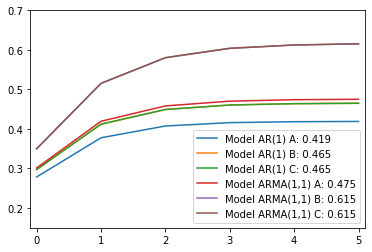

In [168]:
for rrho, name in zip(ar_component, model_name):
    dynamic = compute_dynamics(change, rrho, T)
    plt.plot(dynamic-1, label = name +': ' +  str(round(max(dynamic)-1,3)))
    
plt.xlim([-0.1, 5.1])
plt.ylim([0.15, .7])
plt.legend()
plt.savefig('Income_dynamics_stationary_models.png')

print('An increase 1 pp in Y(t-1) increases an accumulated of 0.615 pp future income in approximately 5 years')

## Income dynamics including unobserved shocks (Model B with MA component):

In [156]:
predictionError1B = ar.predict_modelB(y_demean, xx_demean, parameters_hat_1B)[1:,:]
dynamicList = []
for ii in range(predictionError1B.shape[1]):
    dynamic =  compute_dynamics_shocked(change, 
                                        parameters_hat_B[4], 
                                        predictionError1B[:,ii],
                                        parameters_hat_B[5], 
                                        parameters_hat_B[6],
                                        11)

    dynamicList.append(dynamic)
    

dynamicList = np.array(dynamicList)

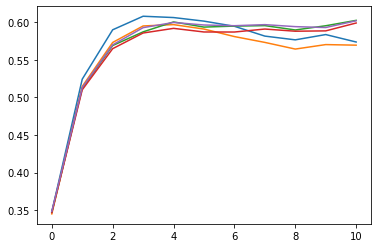

In [166]:
for ii in range(5): plt.plot(dynamicList[ii*10:(ii+1)*20].mean(0) -1, label = str(ii))

In [174]:
print([
parameters_hat_A[-2],
(parameters_hat_B[-3],parameters_hat_B[-2]),
(parameters_hat_C[-3],parameters_hat_C[-2]),
(parameters_hat_D[-3],parameters_hat_D[-2]),
])

[0.03001320410036725, (0.10186575196210666, 0.004497495869354055), (0.10186578670645652, 0.004497525958107975), (0.4834001439763316, -0.0548980023406485)]


In [172]:
sigmaList = [
parameters_hat_1A[-1],
parameters_hat_1B[-1],
parameters_hat_1C[-1],
parameters_hat_1D[-1],
parameters_hat_A[-1],
parameters_hat_B[-1],
parameters_hat_C[-1],
parameters_hat_D[-1]
]
print(sigmaList)

[0.36149133632424263, 0.3593437098290835, 0.35934372245892193, 0.4546900635357474, 0.361438889718106, 0.3488037623478042, 0.3488037553325901, 0.40410317258796585]
